# Plot best MSLP analogue of ERA5 event in CRCM5-LE 

## And define precip mask

### Packages and Directories

In [1]:
# --- Imports ---
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import dask
from dask.distributed import Client, LocalCluster
from scipy.interpolate import griddata
from statsmodels.stats.multitest import fdrcorrection
import calendar
from datetime import datetime, timedelta
import cftime

from scipy import ndimage

import cartopy.crs as ccrs
import cartopy.feature as cfeature

# --- Custom Functions ---
# sys.path.append('/home/portal/script/python/precip_Cristina/')                    # tintin
sys.path.append('/home/alice/Desktop/work/git/myISACcode/python/precip_Cristina')   # alice
import functions_analogues_PrMax as fanPM
import functions_analogues_LUCAFAMOSS as fan

In [2]:
# Define directories for data and figures
# # tintin
# CERRA_dir = '/work_big/users/clima/portal/CERRA-Land/'
# ERA5_dir = '/work_big/users/clima/portal/ERA5/'
# CRCM5_dir = '/work_big/users/clima/portal/CRCM5-LE/'
# fig_dir = '/home/portal/figures/analogues/'

# alice
CERRA_dir = '/media/alice/Crucial X9/portal/data_CNR/CERRA-Land/'
ERA5_dir = '/media/alice/Crucial X9/portal/data_CNR/ERA5/'
CRCM5_dir = '/media/alice/Crucial X9/portal/data_CNR/CRCM5-LE/'
fig_dir = '/home/alice/Desktop/CNR/ENCIRCLE/materiale_alice/figures/analogues/'

### Parameters

In [5]:
var_analogues = 'psl'  # Variable for analogues
no_membs = 32  # Number of members in the ensemble
year_range = [2004, 2023]  # Year range for analysis

### Identifies BAM event in time and space

In [6]:
# Best model analogue selection
lselect = 'alert-regions'  # 'Italy' or 'wide-region' or 'alert-regions'
no_node = 1
no_event = 1
# Upload info on Best Model Analogue (BAM)
BAM_info = fanPM.get_best_model_analogue_info(no_node, no_event, var_analogues)
time_event = datetime.strptime(BAM_info['date'], "%Y-%m-%d")
time_event = cftime.DatetimeNoLeap(time_event.year, time_event.month, time_event.day, hour=0, minute=0, second=0)
doy_event = time_event.timetuple().tm_yday
member_event = BAM_info['member']
# Define lon-lat box of event
box_event = fanPM.box_event_PrMax_alertregions(no_node,no_event)

# Event information
print('BAM member:', BAM_info['member'])
print('BAM time:', BAM_info['date'])
print('BAM DOY:', doy_event)
# print('Event box:', box_event)

BAM member: kbw
BAM time: 2019-11-25
BAM DOY: 329


In [7]:
# Defines the months for analogue selection
month_event = time_event.month
months_sel = [month_event-1, month_event, month_event+1]
# Get the month names
month_names = [calendar.month_abbr[month] for month in months_sel]
# Extract the initials
str_months = ''.join([name[0] for name in month_names])

# Months for analogue selection
print('Season (selection of 3 months) for analogue search:', str_months)

# Year event
year_event = time_event.year

Season (selection of 3 months) for analogue search: OND


### Upload event data in CRCM5-LE (anom & clim)

In [8]:
varname = 'psl'

In [9]:
# List file paths (anomalies and climatology)
BAM_files, BAM_files_clim = fanPM.get_anomaly_climatology_paths_CRCM5_bymonth(CRCM5_dir, var_analogues, [member_event], [[time_event]])

### Open CRCM5 data

In [10]:
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(BAM_files, combine='by_coords', expand_member_dim=True)
list_ds_clim = fanPM.open_member_datasets(BAM_files_clim, combine='by_coords', expand_member_dim=True)
# ??? Can.t open in parallel (gives error) 

# Concatenate and scale
dmslp_LE = xr.concat(list_ds, dim='member')[varname] * 0.01
mslp_LE = xr.concat(list_ds_clim, dim='member')[varname] * 0.01

Opening files for member: kbw
Opening files for member: kbw


In [11]:
# Select the time of the event
dmslp_event_LE = dmslp_LE.sel(time=time_event).squeeze('member')
doy_clim = mslp_LE.time.dt.dayofyear.values
mask_time = doy_clim == doy_event
mslp_event_clim_LE = mslp_LE.sel(time=mask_time).squeeze('time').squeeze('member')

# Select lon lat mask for the event
lon_mask_LE, lat_mask_LE = fanPM.lonlat_mask(dmslp_event_LE.lon.values, dmslp_event_LE.lat.values, box_event)
mask_LE = lat_mask_LE[:, np.newaxis] & lon_mask_LE
mask_xr_LE = xr.DataArray(
    mask_LE,
    dims=["lat", "lon"],
    coords={"lat": dmslp_event_LE.lat.values, "lon": dmslp_event_LE.lon.values},
)
dmslp_event_LE = dmslp_event_LE.where(mask_xr_LE, drop=True)
mslp_event_clim_LE = mslp_event_clim_LE.where(mask_xr_LE, drop=True)

### Plot BAM

/tmp/ipykernel_10900/2137732785.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


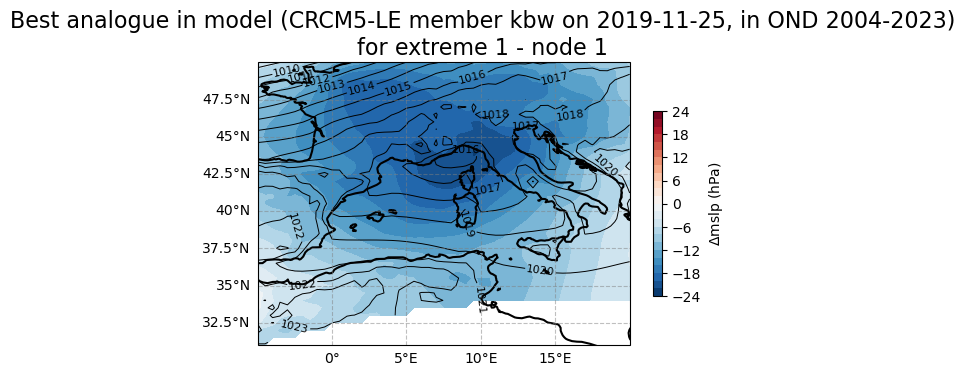

In [12]:
# Plot LE analogue mean
fig, ax = plt.subplots(
    nrows=1, ncols=1, figsize=(6, 4),
    sharey=True,
    subplot_kw={'projection': ccrs.PlateCarree()}
    )

fanPM.plot_anom_event(ax, 'mslp', dmslp_event_LE.lon, dmslp_event_LE.lat, dmslp_event_LE, mslp_event_clim_LE.values) #
fig.suptitle("Best analogue in model (CRCM5-LE member "+member_event+" on "+str(time_event)[:10]+", in "+str_months+' '+str(year_range[0])+'-'+str(year_range[1])+")"+\
             "\nfor extreme "+str(no_event)+" - node "+str(no_node), fontsize=16)
fig.show()
fig.savefig(fig_dir+'BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

### Open BAM precipitation

In [13]:
precip_paths = fanPM.get_precipitation_paths_CRCM5_bymonth(CRCM5_dir, [member_event], [[time_event]])
# Make list of datasets and add 'member' coordinate
list_ds = fanPM.open_member_datasets(precip_paths, combine='by_coords', expand_member_dim=True)
# Concatenate, scale, choose date and select box
pr_tmp = xr.concat(list_ds, dim='member')['pr'] * 3600 # Convert from mm/s*24 to mm/day
pr_event = pr_tmp.sel(time=time_event + timedelta(hours=12)).squeeze('member')
pr_event = pr_event.where(mask_xr_LE, drop=True)

Opening files for member: kbw


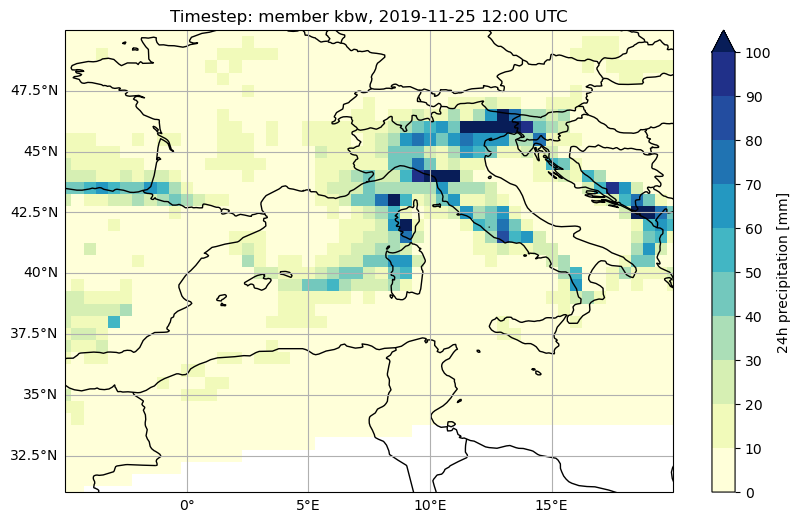

In [14]:
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())

# Plot the precipitation event
timestamp_event = 'member '+ member_event + ', ' + str(pr_event.time.dt.strftime("%Y-%m-%d %H:%M UTC").values)
fanPM.plot_precipitation(ax, timestamp_event, box_event, pr_event, 
                         precip_levels=np.arange(0, 105, 10))

# Save the figure
fig.savefig(fig_dir+'pr_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

### Identify connected mask of 24h-precip > threshold

In [15]:
# Threshold: precip > pr_thresh
pr_thresh = 20  # mm/day
mask_pr = pr_event > pr_thresh

# Label connected components
structure = np.ones((3,3))  # 8-connectivity
labeled_mask, num_features = ndimage.label(mask_pr, structure=structure)
labeled_mask = labeled_mask.astype(float)
labeled_mask[labeled_mask == 0] = np.nan

/tmp/ipykernel_10900/896936509.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_features)


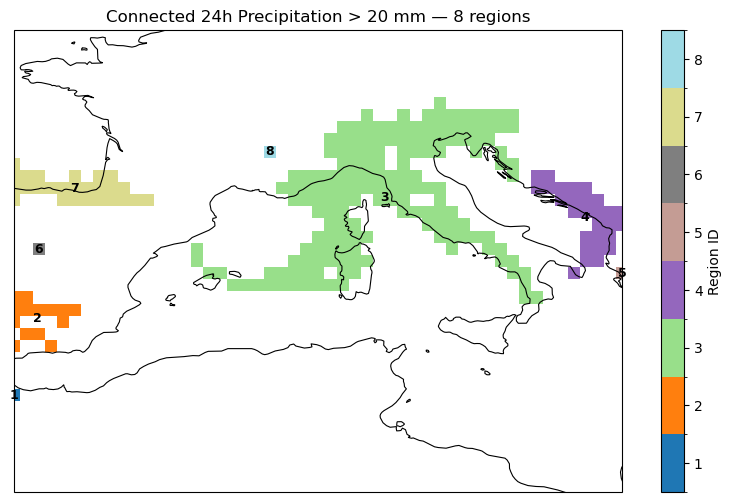

In [16]:
import matplotlib as mpl

fig, ax = plt.subplots(
    figsize=(10, 6),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)
# ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot mask
cmap = plt.cm.get_cmap('tab20', num_features)
bounds = np.arange(0.5, num_features + 1.5, 1)  # boundaries between IDs
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
im = ax.pcolormesh(pr_event.lon, pr_event.lat, labeled_mask,
                   cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cb = plt.colorbar(im, ax=ax, ticks=np.arange(1, num_features + 1))
cb.set_label("Region ID")

# Annotate IDs
for region_id in range(1, num_features + 1):
    coords = np.argwhere(labeled_mask == region_id)
    if coords.size > 0:
        lat_mean = pr_event.lat.values[coords[:, 0]].mean()
        lon_mean = pr_event.lon.values[coords[:, 1]].mean()
        ax.text(lon_mean, lat_mean, str(region_id),
                color="black", ha="center", va="center",
                fontweight="bold", fontsize=9,
                transform=ccrs.PlateCarree())

ax.set_title(f"Connected 24h Precipitation > {pr_thresh} mm — {num_features} regions")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig(fig_dir+'pr-regions_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

### Save mask of most-representative region ID

In [17]:
# Choice of labeled region ID to save
region_id = 3

# Create a mask where only region 5 is kept, others set to 0
region_mask = np.where(labeled_mask == region_id, labeled_mask, 0)
region_mask = region_mask/region_mask.max()

# Convert to a DataArray
region_da = xr.DataArray(region_mask,
                          coords=pr_event.coords,
                          dims=pr_event.dims,
                          name=f'pr_mask')
region_da.to_netcdf(f'./analogue_data/BAM_data/pr-mask_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.nc')

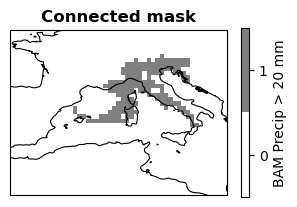

In [18]:
fig, ax = plt.subplots(
    figsize=(3.5, 2.2),
    subplot_kw={'projection': ccrs.PlateCarree()},
)

# White background everywhere
ax.set_facecolor("white")           # Plot area
fig.patch.set_facecolor("white")    # Figure background

# Coastlines & borders
ax.add_feature(cfeature.COASTLINE, linewidth=0.8)

# Data extent
ax.set_extent(box_event, crs=ccrs.PlateCarree())

# Plot the region where region_da == 1
im = ax.pcolormesh(region_da.lon, region_da.lat, region_da == 1,
                   cmap=mpl.colors.ListedColormap(['white', 'grey']), transform=ccrs.PlateCarree())

# Add a colorbar with centered labels
cb = plt.colorbar(im, ax=ax, ticks=[0.25, 0.75])
cb.ax.set_yticklabels(['0', '1'])
cb.set_label(f"BAM Precip > {pr_thresh} mm")

ax.set_title("Connected mask", fontsize=12, weight="bold")
plt.show()
fig.tight_layout()
# Save the figure
fig.savefig('./analogue_data/BAM_data/pr-mask_BAM-'+var_analogues+'_node'+str(no_node)+'_extreme'+str(no_event)+'-alertregions_'+str_months+'_'+str(year_range[0])+'-'+str(year_range[1])+'_CRCM5-LE_'+str(no_membs)+'membs.png')

### Compute average precipitation in region mask

In [21]:
# Average precipitation in region mask
mean_pr_in_mask = pr_event.where(region_da).mean().values
print(f"Average precipitation in region ID {region_id}: {mean_pr_in_mask:.2f} mm/day")

Average precipitation in region ID 3: 47.13 mm/day
